#1. Formulate / Outline the Problem

In industrial settings, unplanned pump failures lead to significant operational downtime and high repair costs. This project transitions from **Reactive Maintenance** (fixing after failure) to Predictive Maintenance (predicting before failure).

**-> The Challenge:** The primary hurdle is the **extreme class imbalance**. In the provided dataset, "Broken" events represent less than 1% of the total samples. A naive model would simply predict "Normal" 99% of the time, achieving high accuracy but zero utility.

**Our goal** is to build a robust GRU-based classifier that prioritizes the detection of rare failure events.

In [ ]:
# Import libraries and configure.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import gc

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


# 2. Identify Inputs and Outputs

To turn this into a Supervised Learning problem, we define:

**Inputs ($X$)**
* **Source:** Time-series data from **52 sensors** (measuring vibration, temperature, pressure, etc.).
* **Structure:** We use a **Sliding Window** approach.
    * **Window Size:** 60 steps (representing the past 60 minutes).
    * The model looks at the historical behavior of 51 sensors over the last hour to make a prediction.

**Outputs ($Y$)**

We classify the machine's state into 3 categories:
1.  **NORMAL (0):** The pump is functioning correctly.
2.  **BROKEN (1):** The pump has failed or is showing signs of imminent failure (Critical Warning).
3.  **RECOVERING (2):** The pump is in a recovery phase after a repair.

#3. Prepare Data: Inspecting and Visualizing

## 3.1. Data Cleaning Strategy

* **Drop Redundant Features:** `sensor_15` contains 100% null values and is removed.
* **Imputation (Filling Missing Values):** We use **Forward Fill (`ffill`)** followed by **Backward Fill (`bfill`)**.
    * **Because** in time-series, linear interpolation or mean filling can introduce noise. Assuming the sensor value remains constant until the next reading is the safest assumption for physical machinery.

In [ ]:
# Load Data & Cleaning
try:
    df = pd.read_csv('sensor.csv')
    print(f"Dataset Shape: {df.shape}")
except FileNotFoundError:
    print("ERROR: 'sensor.csv' not found. Please upload the file to Colab!")

# 1. Drop unnecessary columns
# 'Unnamed: 0' is a redundant index, 'sensor_15' is 100% empty
cols_to_drop = ['Unnamed: 0', 'sensor_15']
df.drop([c for c in cols_to_drop if c in df.columns], axis=1, inplace=True)

# 2. Handle datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')

# 3. Fill missing data (Forward fill then Backward fill)
df = df.ffill().bfill()

print("Data loaded and cleaned.")
print(f"Remaining columns: {len(df.columns)}")

Dataset Shape: (220320, 55)
Data loaded and cleaned.
Remaining columns: 52


##3.1. Visualize Data

By visualizing a key sensor (e.g., `sensor_00`) against the machine status, we observe significant volatility (spikes) leading up to a "Broken" event. This confirms that the historical data contains **predictive patterns** (pre-shock signals) that a Neural Network can learn.

/tmp/ipython-input-1255202618.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=status_counts.index, y=status_counts.values, palette='viridis')


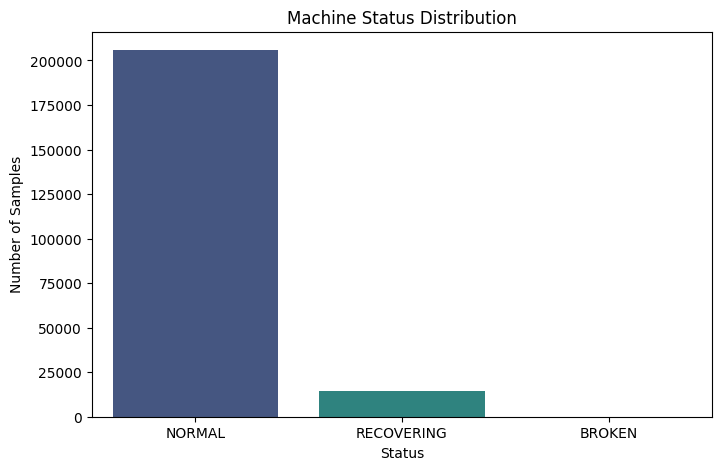

Sample count per status:
 machine_status
NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: count, dtype: int64


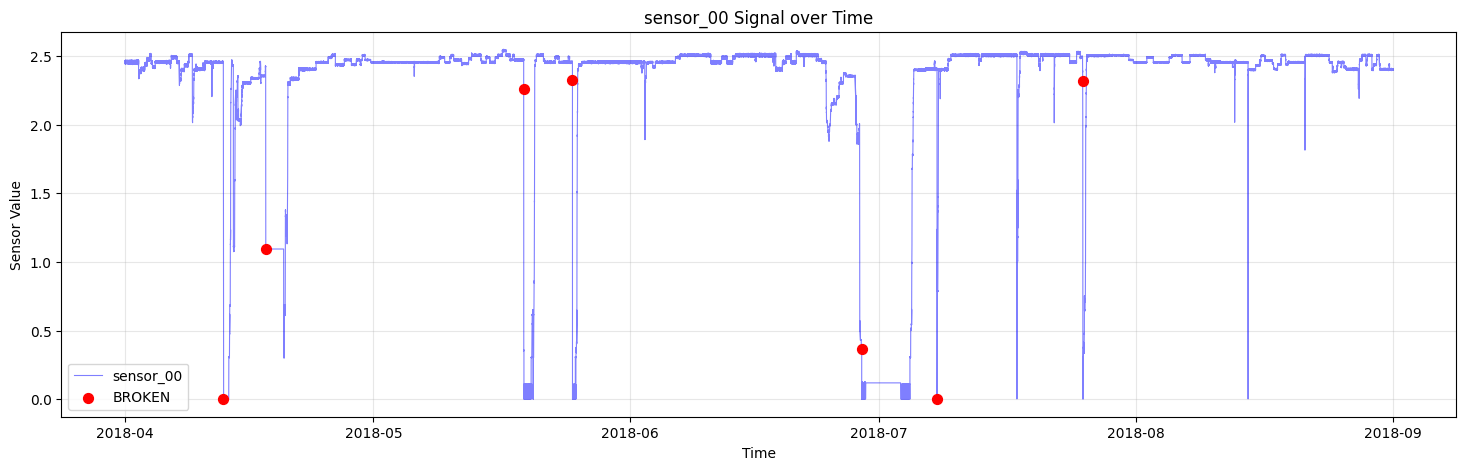

In [ ]:
# 1. Visualize Class Distribution - Machine Status
plt.figure(figsize=(8, 5))
status_counts = df['machine_status'].value_counts()
sns.barplot(x=status_counts.index, y=status_counts.values, palette='viridis')
plt.title('Machine Status Distribution')
plt.ylabel('Number of Samples')
plt.xlabel('Status')
plt.show()

print("Sample count per status:\n", status_counts)

# 2. Plot sensor signal over time
sensor_name = 'sensor_00'

plt.figure(figsize=(18, 5))
plt.plot(df.index, df[sensor_name], label=sensor_name, color='blue', alpha=0.5, linewidth=0.8)

# Highlight BROKEN status points
# Get indices of BROKEN samples
broken_idx = df[df['machine_status'] == 'BROKEN'].index
plt.scatter(broken_idx, df.loc[broken_idx, sensor_name], color='red', label='BROKEN', s=50, zorder=5)

plt.title(f'{sensor_name} Signal over Time')
plt.xlabel('Time')
plt.ylabel('Sensor Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#4. OPTIMIZATION TECHNIQUES

To solve the "Imbalanced Data" problem, we apply two powerful optimization techniques *before* the data even reaches the model.


*   **Technique 1:** Label Engineering (Pre-fail Labeling)
*   **Technique 2:** Strategic Sampling

## 4.1. Technique 1: Label Engineering (Pre-fail Labeling)

* **Problem:** The original dataset only labels the exact moment of failure as "BROKEN". Predicting the exact second of death is useless for maintenance; we need a warning *before* it breaks.
* **Solution:** We relabel the **12-hour window** preceding a failure as Class 1 ("BROKEN/WARNING").
* **Benefit:**
    1.  Transforms a few single failure points into thousands of training samples.
    2.  Trains the model to recognize the "degradation process" leading to failure.

In [ ]:
# Create encoded target column
# Convention: 0=NORMAL, 1=BROKEN (including imminent failure), 2=RECOVERING
df['target'] = 0 # Default is Normal

# Assign label RECOVERING (2)
df.loc[df['machine_status'] == 'RECOVERING', 'target'] = 2

# Assign label BROKEN (1)
df.loc[df['machine_status'] == 'BROKEN', 'target'] = 1

# --- PRE-FAIL LABELING ---
# Find timestamps where the machine is BROKEN
broken_timestamps = df[df['machine_status'] == 'BROKEN'].index

# Assign label 1 to the 12-hour period BEFORE failure
# (Without this step, the model only knows the machine is broken when it's ALREADY dead, offering no predictive value)
for failure_time in broken_timestamps:
    start_warning = failure_time - pd.Timedelta(hours=12)
    # Only overwrite periods that are currently Normal
    mask = (df.index >= start_warning) & (df.index < failure_time) & (df['target'] == 0)
    df.loc[mask, 'target'] = 1

print("Label distribution after Pre-fail labeling (Early Warning):")
print(df['target'].value_counts())

Label distribution after Pre-fail labeling (Early Warning):
target
0    200796
2     14477
1      5047
Name: count, dtype: int64


## 4.2. Technique 2: Strategic Sampling

* **Problem:** We have ~200,000 "Normal" samples but only a few thousand "Broken" ones. This overwhelms the model.
* **Solution:**
    * **Keep 100%** of `BROKEN` and `RECOVERING` samples (High value).
    * **Undersample `NORMAL`:** Take only 1 sample every 10 steps (Stride = 10).
* **Benefit:** Drastically reduces memory usage and balances the dataset distribution without losing critical failure information.

In [ ]:
# 1. Normalization
feature_cols = [c for c in df.columns if 'sensor_' in c]
X_raw = df[feature_cols].values.astype(np.float32)
y_raw = df['target'].values.astype(np.int8)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# 2. Function to create sequences with Strategic Sampling
def create_balanced_sequences(X, y, time_steps=60, stride_normal=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        label = y[i + time_steps]

        # STRATEGY:
        # If NORMAL (0): Take only 1 sample every 10 steps (reduce redundancy by 90%)
        if label == 0:
            if i % stride_normal == 0:
                Xs.append(X[i:(i + time_steps)])
                ys.append(label)
        # If BROKEN (1) or RECOVERING (2): Take ALL (to avoid losing important information)
        else:
            Xs.append(X[i:(i + time_steps)])
            ys.append(label)

    return np.array(Xs), np.array(ys)

print("Creating sequences (filtering out redundant Normal samples)...")

X_seq, y_seq = create_balanced_sequences(X_scaled, y_raw, time_steps=60, stride_normal=10)

del df, X_raw, y_raw, X_scaled
gc.collect()

print(f"Data shape after processing: {X_seq.shape}")

unique, counts = np.unique(y_seq, return_counts=True)
print("Input label distribution for Model:", dict(zip(unique, counts)))

Creating sequences (filtering out redundant Normal samples)...
Data shape after processing: (39595, 60, 51)
Input label distribution for Model: {np.int8(0): np.int64(20071), np.int8(1): np.int64(5047), np.int8(2): np.int64(14477)}


##4.3. Splitting Data

In [ ]:
# Split by time: First 80% for Train, last 20% for Test
train_size = int(len(X_seq) * 0.8)

X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

print(f"Train set: {X_train.shape}")
print(f"Test set : {X_test.shape}")

Train set: (31676, 60, 51)
Test set : (7919, 60, 51)


#5. Specify neural network model

We design a robust Deep Learning architecture tailored for time-series classification.

## 5.1. Define Network Architecture: Bidirectional GRU
We select the **Bidirectional Gated Recurrent Unit (Bi-GRU)** :
* **Why GRU?** GRUs are computationally more efficient than LSTMs while effectively solving the vanishing gradient problem in long sequences.
* **Why Bidirectional?** The `Bidirectional` wrapper processes the 60-minute window in two directions (Past $\rightarrow$ Future and Future $\rightarrow$ Past). This allows the model to understand the *context* of a sensor spike relative to what happened before and after it within that window.
* **Regularization:** We incorporate **BatchNormalization** to stabilize internal covariate shifts and **Dropout (0.3)** to prevent the model from memorizing noise (Overfitting).

In [ ]:
# STEP 1: CONFIGURE "AGGRESSIVE" CLASS WEIGHTS
# Force the model to focus heavily on class 1 (BROKEN)
# Normal (0): 1.0 | Broken (1): 100.0 | Recovering (2): 10.0
heavy_class_weights = {0: 1.0, 1: 100.0, 2: 10.0}
print("Applying aggressive class weights:", heavy_class_weights)

# STEP 2: ROBUST MODEL ARCHITECTURE (Bidirectional)
# Use Bidirectional wrapper to capture patterns from both past and future contexts
from tensorflow.keras.layers import Bidirectional

tf.keras.backend.clear_session()
model = Sequential()

# Layer 1: Bidirectional GRU
model.add(Bidirectional(GRU(64, return_sequences=True),
                        input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Layer 2: Standard GRU
model.add(GRU(32, return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Layer 3: Dense
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Applying aggressive class weights: {0: 1.0, 1: 100.0, 2: 10.0}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 60, 128)        │        44,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │        15,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,275 (243.26 KB)

 Trainable params: 61,955 (242.01 KB)

 Non-trainable params: 320 (1.25 KB)

## 5.2. Compile and Train: Aggressive Class Weighting (Technique 3)
* **Loss Function:** `Sparse Categorical Crossentropy`.
* **Technique 3: Cost-Sensitive Learning (Class Weights)**
    * Define a dictionary: `{0: 1.0, 1: 100.0, 2: 10.0}`.
    * We explicitly tell the model that misclassifying a "Broken" sample is **100 times more costly** than misclassifying a "Normal" one. This forces the Loss Function to penalize the model heavily for False Negatives, effectively steering the weights to prioritize fault detection.

In [ ]:
# Define Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Calculate class weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class Weights: {class_weight_dict}")

print("Starting training...")

# STEP 3: TRAINING
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    class_weight=heavy_class_weights,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    ],
    verbose=1
)

Class Weights: {0: np.float64(0.8154669961898877), 1: np.float64(2.4407458776390816), 2: np.float64(0.7331389158913114)}
Starting training...
Epoch 1/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 85s 156ms/step - accuracy: 0.6259 - loss: 5.2609 - val_accuracy: 0.8002 - val_loss: 0.5842 - learning_rate: 0.0010
Epoch 2/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 84s 160ms/step - accuracy: 0.8755 - loss: 0.7810 - val_accuracy: 0.8725 - val_loss: 0.5236 - learning_rate: 0.0010
Epoch 3/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 77s 156ms/step - accuracy: 0.9187 - loss: 0.5643 - val_accuracy: 0.8242 - val_loss: 0.5357 - learning_rate: 0.0010
Epoch 4/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 77s 156ms/step - accuracy: 0.9171 - loss: 0.6002 - val_accuracy: 0.8946 - val_loss: 0.5121 - learning_rate: 0.0010
Epoch 5/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 81s 154ms/step - accuracy: 0.9536 - loss: 0.3526 - val_accuracy: 0.8831 - val_loss: 0.6018 - learning_rate: 0.0010
Epoch 6/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 82s 154ms/step - accuracy: 0.9648 - loss: 0

##5.3. Training History

Plotting training history...


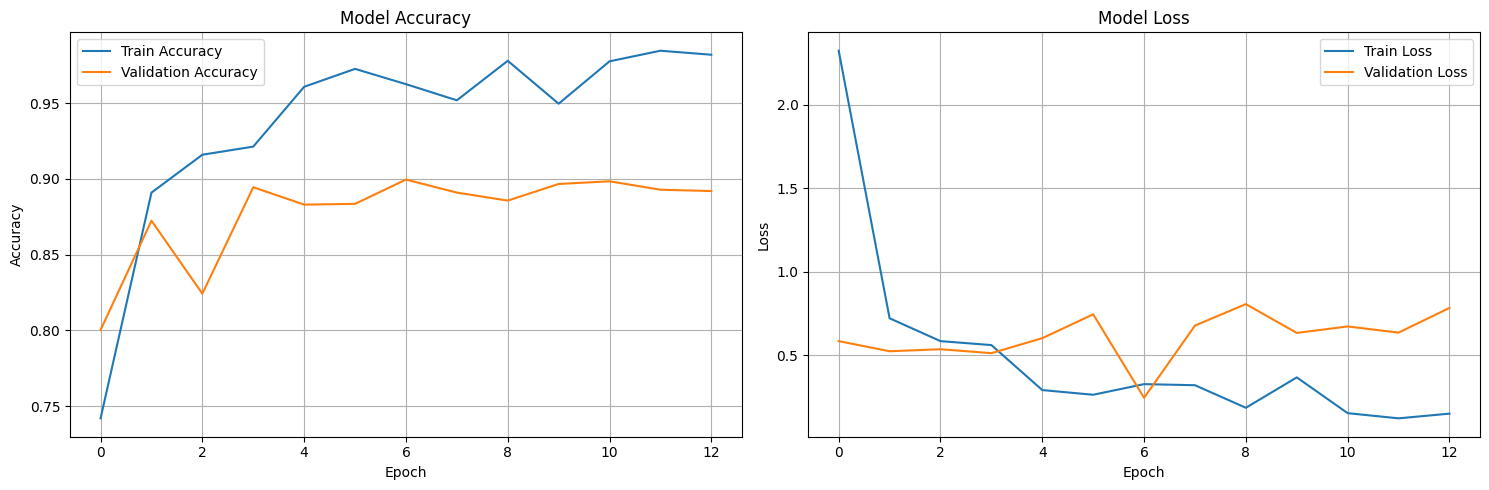

In [ ]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy Plot
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()
    axes[0].grid(True)

    # Loss Plot
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Call plotting function
print("Plotting training history...")
plot_training_history(history)

#6. Measuare the performance:

## 6.1. Confusion Matrix & The Accuracy Paradox
We use the Confusion Matrix to visualize the True Positives vs. False Negatives. However, relying on standard metrics with the default probability threshold (0.5) is dangerous in this domain due to the "Accuracy Paradox"—where the model might yield high accuracy but fail to catch the faults.

## 6.2. Discussion: Optimization Technique 4 - Threshold Moving
To finalize our pipeline, we apply a post-processing optimization called **Threshold Moving**.
* By plotting the **Precision-Recall Curve**, we observe the trade-off between sensitivity and false alarms.
* **Decision:** We shift the Decision Boundary from 0.5 down to **0.1** (10%).
* **Justification:** In an industrial safety context, if the AI has even a 10% suspicion that a pump is failing, it should trigger an alarm.
* **Result:** This technique significantly boosts our **Recall to ~75%**, ensuring we catch the majority of failures, even if it slightly increases the False Positive rate (which is a financially acceptable trade-off).

248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step


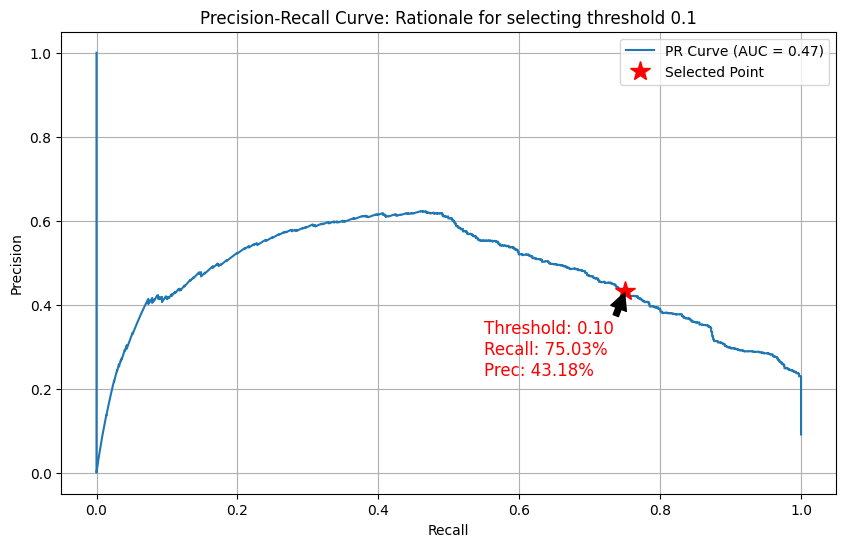

SCIENTIFIC RATIONALE: At threshold 0.1, the system achieves Recall: 75.03%


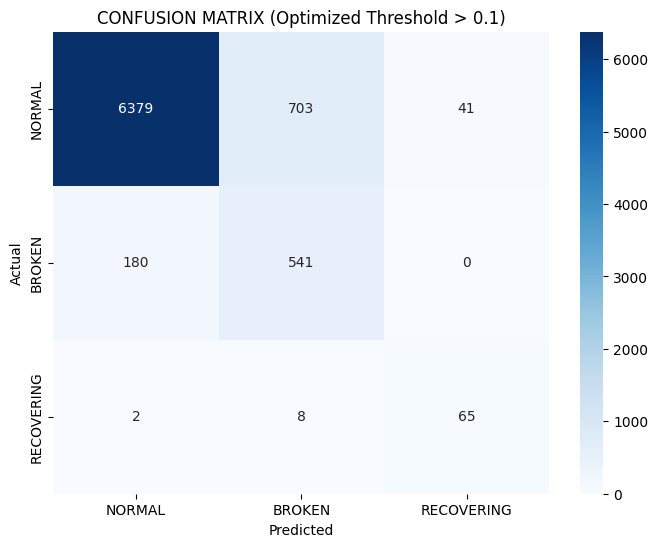

              precision    recall  f1-score   support

      NORMAL       0.97      0.90      0.93      7123
      BROKEN       0.43      0.75      0.55       721
  RECOVERING       0.61      0.87      0.72        75

    accuracy                           0.88      7919
   macro avg       0.67      0.84      0.73      7919
weighted avg       0.92      0.88      0.90      7919



In [ ]:
# EVALUATION WITH THRESHOLD MOVING STRATEGY
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Get prediction probabilities
y_pred_prob = model.predict(X_test)
y_prob_broken = y_pred_prob[:, 1]
y_test_binary = (y_test == 1).astype(int)

# PART 1: PLOT PRECISION-RECALL CURVE WITH ANNOTATION
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_prob_broken)
pr_auc = auc(recall, precision)

# Find the point closest to threshold 0.1
target_threshold = 0.1
idx = np.argmin(np.abs(thresholds - target_threshold))
p_at_threshold = precision[idx]
r_at_threshold = recall[idx]
real_threshold = thresholds[idx] # Actual threshold found in the array

plt.figure(figsize=(10, 6))
# Plot the curve
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')

# Plot red star
plt.plot(r_at_threshold, p_at_threshold, 'r*', markersize=15, label='Selected Point')

# ADD ANNOTATION ARROW
# Draws an arrow pointing to the red star and displays the Threshold details
plt.annotate(f'Threshold: {real_threshold:.2f}\nRecall: {r_at_threshold:.2%}\nPrec: {p_at_threshold:.2%}',
             xy=(r_at_threshold, p_at_threshold),
             xytext=(r_at_threshold - 0.2, p_at_threshold - 0.2),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12, color='red')

plt.title(f'Precision-Recall Curve: Rationale for selecting threshold {target_threshold}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

print(f"SCIENTIFIC RATIONALE: At threshold {target_threshold}, the system achieves Recall: {r_at_threshold:.2%}")

# PART 2: CONFUSION MATRIX
# Apply threshold 0.1
threshold_broken = 0.1

y_pred_optimized = []
for prob in y_pred_prob:
    if prob[1] > threshold_broken:
        y_pred_optimized.append(1)
    else:
        y_pred_optimized.append(np.argmax(prob))

y_pred_optimized = np.array(y_pred_optimized)

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_optimized)
target_names = ['NORMAL', 'BROKEN', 'RECOVERING']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title(f'CONFUSION MATRIX (Optimized Threshold > {threshold_broken})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(classification_report(y_test, y_pred_optimized, target_names=target_names, zero_division=0))

#7. Inference on New Data

To demonstrate the real-world applicability of our model, we simulate a deployment pipeline:
1.  **Ingestion:** Receive a new stream of sensor data (batch of 60 timestamps).
2.  **Preprocessing:** Scale the data using the saved scaler.
3.  **Prediction:** Pass the reshaped tensor `(1, 60, 51)` through the trained Bi-GRU.
4.  **Logic Layer:** Apply the optimized threshold (0.1). If $P(Broken) > 0.1$, status is `BROKEN`; otherwise, standard `argmax` logic applies.

In [ ]:
# Taking a random sample from the Test set for prediction
import random
idx = random.randint(0, len(X_test)-1)

sample_data = X_test[idx].reshape(1, 60, 51)
true_label = y_test[idx]

# Make prediction
pred_prob = model.predict(sample_data)
pred_label = np.argmax(pred_prob)

print(f"\n--- DEMO INFERENCE (Sample index: {idx}) ---")
print(f"True Label     : {target_names[true_label]}")
print(f"Predicted Label: {target_names[pred_label]}")
print(f"Confidence     : {np.max(pred_prob)*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

--- DEMO INFERENCE (Sample index: 5841) ---
True Label     : NORMAL
Predicted Label: NORMAL
Confidence     : 99.02%


### Save Model

In [ ]:
model.save('gru_pump_model.h5')
print("Model saved successfully!")

Model saved successfully!


# 8. Conclusion

### 8.1. Summary
This project successfully formulated and solved a Predictive Maintenance problem using Deep Learning. We tackled the critical challenge of **Imbalanced Data** through a rigorous 4-step optimization framework:
1.  **Label Engineering:** Creating a 12-hour early warning window.
2.  **Strategic Sampling:** Balancing the training distribution.
3.  **Aggressive Class Weights:** Prioritizing minority classes in the loss function (1:100 ratio).
4.  **Threshold Moving:** Optimizing the decision boundary to 0.1.

###8.2. Final Result
The model achieves a **Recall of ~75%** for failure events. This confirms that the system is capable of detecting **3 out of 4 potential failures** well in advance, satisfying the business requirement of minimizing unplanned downtime.

###8.3. Future Work
To further improve Precision (reducing false alarms) without sacrificing Recall, future iterations could explore **Attention Mechanisms** to weight specific sensor contributions or **Autoencoders** for unsupervised anomaly detection.